<a href="https://colab.research.google.com/github/psukphranee/Machine-Learning-Projects/blob/master/Hands-On%20Machine%20Learning/Chapter%202%3A%20End-to-End%20Machine%20Learning%20Project/Housing%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Data Regresion Project

This is an end-to-end project guided by Appendix B of the Hands on Machine Learning book. The appendix provides guidelines of approaching a problem at high level.

## Frame the Problem and Look at the Big Picture

We are data scientist working at an investment company. We are given California census data that contains various metrics for each block group (the smallest unit for which data is published). We'll refer to these as districts. We will use this data to build a housing price model. Our model should be able to predict median housing price given such metrics.

### Define the objective in business terms. How will your solution be used?
Our predicted values will be fed downstream along with other signals. The downstream system will determine if it's worth investing in a given area. 

### What are the current solutions/workarounds?
In this hypothetical company, the median housing prices are estimated manually by experts. Information is gathered by experts and when median housing prices are not availble, they estimate it using complex rules. In the case where they managed to find the median housing price, the experts were off by more than 20%. 

### How should you frame this problem?
This is a supervised learning task since we will use labeled data to train our model. The target value is continous so we will be using regression. Particularly, this is a univariate multiple regression task; we use many variables to predict a single value. The model will use the entire data set to learn before going live and will not learn from new data. Thus this an offline batch learning problem. 

### Performance Measure
We'll use the l2-norm to measure the distance between vectors of predicted value vs actual value. 



## Getting the Data

We'll automate this by writing a function that fetches the housing data. When grabbing data off of GitHub, the format of the url becomes
```
https://raw.githubusercontent.com/user/repository/branch/filename.
```


In [ ]:
import urllib.request
import os
import tarfile

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'
SAVE_PATH = os.path.join('datasets', 'housing') #local path to save file to

#create function to get data: takes url of source and path to save to
def get_housing_data(src_url=HOUSING_URL, save_path=SAVE_PATH):
    #file to be downloaded is a tarball and will need to be unpackaged
    os.makedirs(save_path, exist_ok=True) #create path to save file.
    save_file = os.path.join(save_path, "housing.tgz")
    urllib.request.urlretrieve(src_url, save_file) #download file
    
    housing_tgz = tarfile.open(save_file)
    housing_tgz.extractall(path=save_path)
    housing_tgz.close()

get_housing_data()


This archive only has one csv file that we'll load into a DataFrame.

In [ ]:
os.listdir(SAVE_PATH)

['housing.tgz', 'housing.csv']

In [ ]:
#load the extracted data into a Pandas DataFrame
import pandas as pd

housing_df = pd.read_csv(os.path.join(SAVE_PATH, 'housing.csv'))
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


After loading the data into DataFrame, we take a look at the head and gather some basic information on the contents.

In [ ]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


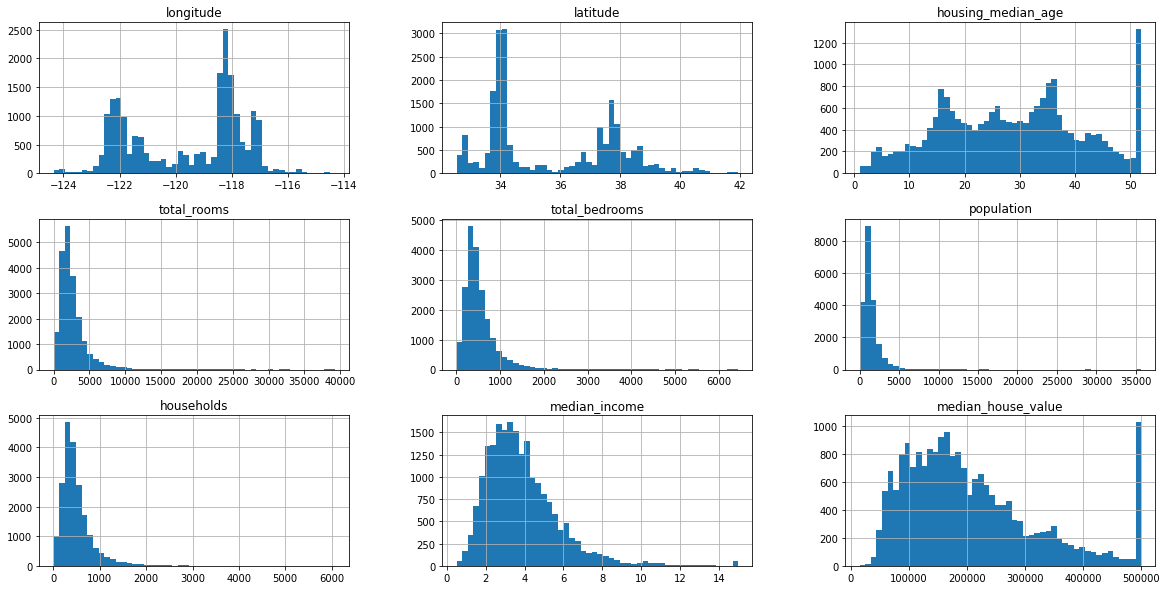

In [ ]:
import matplotlib.pyplot as plt
housing_df.hist(figsize=(20,10), bins=50)
plt.show()

We need to split this data into training and test sets using stratified sampling to avoid sampling bias. In our hypothetical scenario, experts notified us that median income is a very important attribute. We want to ensure the test set is representative of the various categories of incomes of the dataset, which we will need to create. 

How do biases happen when the sampling is not representative of the income categories? Consider the case were random sampling happens to select samples from only one income category. Then our model would assign a weight to this feature that suggest it's not a significant factor. This is contrary to what we've been told be our experts. 

In [ ]:
import numpy as np

housing_df['income_cat'] = pd.cut(housing_df['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1,2,3,4,5])

In [ ]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

for train_indices, test_indices in splitter.split(housing_df, housing_df['income_cat']):
    #print(train_indices, test_indices)
    strat_train_set = housing_df.iloc[train_indices]
    strat_test_set = housing_df.iloc[test_indices]

In [ ]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set['income_cat'])

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_cat, dtype: float64

In [ ]:
#Drop the income_cat column to return the DF's back to normal
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', inplace=True, axis=1)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Explore the Data

We're going to create a copy of this test set for exploration. The dataset is small enough to be copied.

In [ ]:
strat_train_explore = strat_train_set.copy()

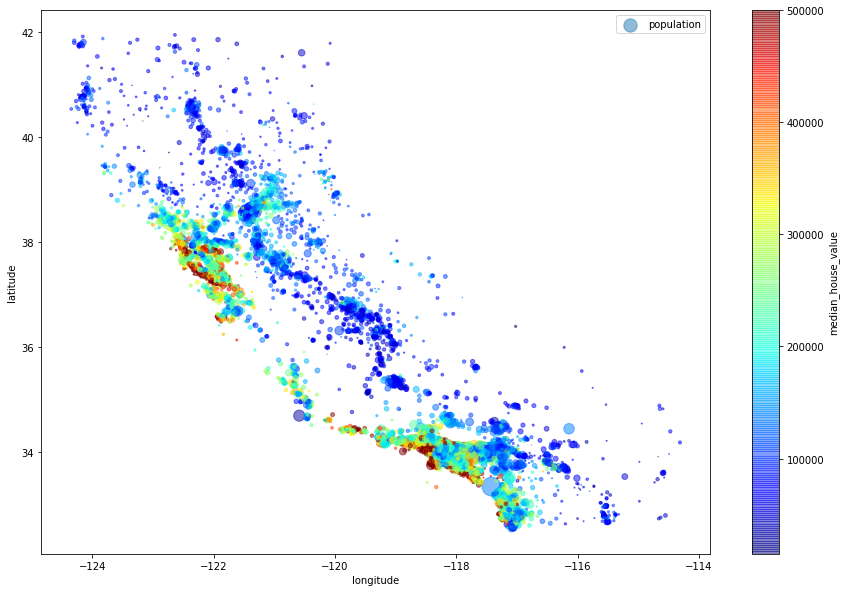

In [ ]:
import matplotlib.pyplot as plt

strat_train_explore.plot(kind='scatter', x='longitude', y='latitude', figsize=(15, 10), s=strat_train_explore['population']/100, label='population',
                        alpha=0.5, c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)

plt.legend()
plt.savefig('housing_scatter_plot')

We scatter plot the longitude vs latitude here with radii varying wrt population size and a color map wrt to median housing price.

In [ ]:
strat_train_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


We take another look at the columns to see kind of data we're working with. All but ocean_proximity is numerical. Below we select four columns that are most correlated with the median_house_value and scatter plot it wrt each other. 

In [ ]:
corr_matrix = strat_train_explore.corr()

In [ ]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

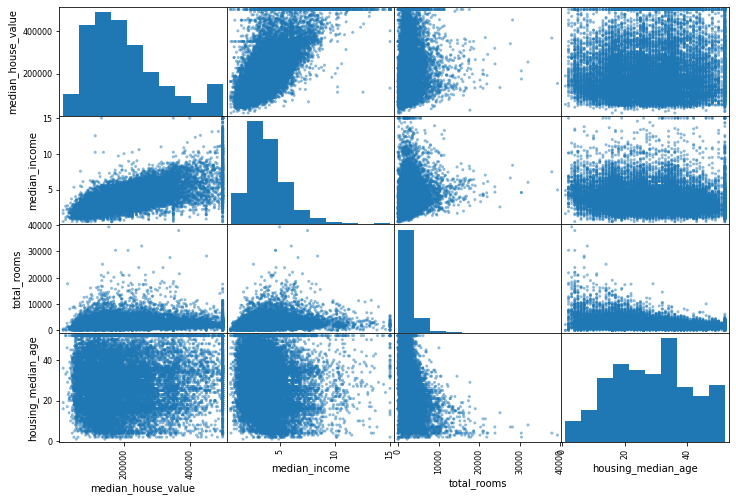

In [ ]:
attrib_interest = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(strat_train_explore[attrib_interest], figsize=(12,8))
plt.show()

We'll explore combining features and look at their correlations wrt housing price. 

In [ ]:
strat_train_explore['bedrooms_per_room'] = strat_train_explore['total_rooms']/strat_train_explore['total_bedrooms']
strat_train_explore['population_per_household'] = strat_train_explore['population']/strat_train_explore['households']
strat_train_explore['rooms_per_household'] = strat_train_explore['total_rooms']/strat_train_explore['households']

In [ ]:
strat_train_explore.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
bedrooms_per_room           0.385271
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
Name: median_house_value, dtype: float64

## Prepare the Data

Start with a fresh copy of the stratified training set. Separate the labels from features.

In [ ]:
#extract features and labels from the stratified training sample into separate parts
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

We're going to have two pipelines, one for numerical data and one for categorical. The numerical pipeline consists of three tranformers: one to impute missing values, one to add feature combinations, and one to scale values so that gradient descent doesn't take forever. The categorical pipeline consists of one transformer that one hot encodes the categroical values. 

The numerical pipeline componenets will be 'assembled' using sklearn's Pipeline. The OHE is a pipeline per se. These two pipelines will be put together under a ColumnTransformer, which selects which columns go down which pipeline.

### Numerical Pipeline

1. Impute missing values
2. Combine and add features
3. Feature scaling

Pipeline() will be used to combine these transformers into a pipeline

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

#columns indices
total_rooms_ix = 3
total_bedroom_ix = 4
population_ix = 5
households_ix = 6

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, bedrooms_per_room=False):
        self.bedrooms_per_room = bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #bedrooms_per_room = strat_train_explore['total_rooms']/strat_train_explore['total_bedrooms']
        population_per_household = X[:, population_ix]/X[:, households_ix]
        rooms_per_household = X[:, total_rooms_ix]/X[:, households_ix]
        if self.bedrooms_per_room:
            bpr = X[:, total__bedroom_ix]/X[:, total_rooms_ix]
            return np.c_[X, population_per_household, rooms_per_household, bpr]
        else:
            return np.c_[X, population_per_household, rooms_per_household]

In [ ]:
#assemble the numerical pipeline
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([('impute', SimpleImputer(strategy='median')),
                         ('attributesAdder', AttributesAdder()),
                         ('scaler', StandardScaler())
                        ])


### Categorical Pipeline

Consists only of the One Hot Encoder. We'll import it here. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

### Combine the Numerical and Categorical Pipelines

Use ColumnTransformer to manage which columns go down which pipeline. 

In [ ]:
from sklearn.compose import ColumnTransformer

#housing's numerical columns
housing_num_col = list(housing.drop('ocean_proximity', axis=1))
#categorical column
cat_col = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ('numerical', num_pipeline, housing_num_col),
        ('categorical', OneHotEncoder(), cat_col)
    ])

Now we transform our housing data using the full pipeline we constructed. The result is an ndarray (16512, 15).

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)

## Select and Train Model

We use the training data to train models and then evaluate how well the model predicts this data. We first select a Linear Regression model and point out that it's underfitting. Its RMSE is comparable to the range of housing price values. This is a best fit line for all of our data points. The average of the orthogonal distance between the line and the training data points is considerable large. Next, we train a Decision Tree Regressor and show that it is over fitting with an RMSE value of 0. This value tells us nothing about the models peformance since it "remembered" the training data and perfectly predicted the labels. We do want to evaulate the Decision Tree Regressor model, but just can't do it the same way as with the Linear Model, i.e. validating with the same set we used to train.

We use a different approach to evaluate the performance of the Decision Tree model called k-fold cross validation. This approach uses a subset of the training data to train the model and the complement of such set to validate the data. The training set is divided into k subsets, k-1 is used to train and 1 to validate. This is one once for each of the k divisions and the result is an array of k scores. 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn.metrics import mean_squared_error

housing_prepared = full_pipeline.transform(housing)
y_pred = lin_reg.predict(housing_prepared)

mse = mean_squared_error(housing_labels, y_pred)
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

RMSE:  68911.7605423384


The RMSE of this model is unsatisfactory. Most district homes are in the 120k-265k range. This model underfitted. Options are try to add more features, regularize less (not applicable), or try a better model.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dec_tree_reg = DecisionTreeRegressor()
dec_tree_reg.fit(housing_prepared, housing_labels)
y_pred_dtr = dec_tree_reg.predict(housing_prepared)
rmse_dtr = np.sqrt(mean_squared_error(y_pred_dtr, housing_labels))
rmse_dtr

0.0

The Decision Tree Regressor severely overfitted giving us no metric on its performance. Use k-fold cross validation to get k scores for how it performed on each fold.

In [ ]:
from sklearn.model_selection import cross_val_score

#cross_val_score expects a utility function where greater is better as opposed to a cost function (lower is better). Hence the negative of MSE
scores = cross_val_score(dec_tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
dec_tree_scores_rmse = np.sqrt(-scores)

In [ ]:
#create a display function to display the scores, mean, and stddev
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(dec_tree_scores_rmse)

Scores: [69990.43899969 68735.61495057 68713.46457371 69890.79946565
 69856.05205451 74101.12980953 71286.44073897 71155.25313778
 75535.06478714 69768.52150864]
Mean: 70903.27800261672
Standard deviation: 2136.0430339356676


We perform k-fold x-validation on the linear regressor model also to see how it compares. The linear model does better.

In [ ]:
scores_lin_reg = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
scores_lin_reg_rmse = np.sqrt(-scores_lin_reg)
display_scores(scores_lin_reg_rmse)

Scores: [67461.9308165  67232.2484863  68224.22888082 74716.58955656
 68420.26897488 71610.91469695 65201.58349349 68686.9304607
 72262.5140762  68112.28697795]
Mean: 69192.94964203317
Standard deviation: 2674.1447265970087


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)
rfr_scores = cross_val_score(rfr, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
rfr_scores_rmse = np.sqrt(-rfr_scores)

display_scores(rfr_scores_rmse)

Scores: [49525.1181241  47307.16539768 49518.7002771  52251.77478506
 49237.59212608 53754.96771747 48769.17557407 47909.67245239
 53186.47568519 49888.73391648]
Mean: 50134.93760556291
Standard deviation: 2081.5470762468517


## Fine Tune a Model

In the previous section, we trained and evaluated a few models using a default hyperparameters. In this section, we take try out various combinations of hyperparameters using GridSearchCV. GridSearchCV takes in a list of hyperparameters and corresponding range of values to try out.

We use GridSearchCV to try to find optimal hyperparams for the RandomForestRegressor.

In [ ]:
from sklearn.model_selection import GridSearchCV

rfr_reg = RandomForestRegressor(random_state=42)
params_list = [
               {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
               {'bootstrap':[False], 'n_estimators':[3,10], 'max_features':[2,3,4]}
]

grid_search = GridSearchCV(rfr_reg, params_list, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

!!! Come back to work on this section. Show the attribute importances by name

In [ ]:
grid_search.best_estimator_.feature_importances_

array([9.47573130e-02, 8.59166016e-02, 4.05066619e-02, 2.11653661e-02,
       1.87683190e-02, 1.85136935e-02, 1.73034041e-02, 3.36979060e-01,
       1.00960419e-01, 9.49885861e-02, 1.30655305e-02, 1.47683783e-01,
       2.60235103e-05, 4.90838326e-03, 4.45685550e-03])

## Evaluate the Model on the Test Set



In [43]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value']

X_test_prepared = full_pipeline.transform(X_test)
y_predict = final_model.predict(X_test_prepared)



In [44]:
np.sqrt(mean_squared_error(y_predict, y_test))

46892.82917439705